# Importing packages

In [43]:
import pandas as pd  
import numpy as np 
import datetime  
import time

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier 
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score

# Function definitions

Function to convert a data array back to a dataframe and restore the datatypes. Only restores datatypes `bool`, `int64`, and `string`.

Input:
 - `data_array`: an array that is a subset of the original dataframe `og_df`. All features of `og_df` should be included in the `data_array`, except for the ones in `exclude`

 - `og_df`: the original dataframe

 - `exclude`: an array containing the names of the features that are present in `og_df`, but not in `data_array`
 
Returns:
 - the given array `data_array` as a dataframe

In [44]:
def to_df_restore_dtypes(data_array, og_df, exclude):
    col_names = og_df.drop(exclude, axis=1).columns.tolist() 
    arr_df = pd.DataFrame(data_array, columns = col_names)
    
    bool_columns = og_df.drop(exclude, axis=1).select_dtypes(include='bool').columns.tolist() 
    int_columns  = og_df.drop(exclude, axis=1).select_dtypes(include='int64').columns.tolist() 
    str_columns  = og_df.drop(exclude, axis=1).select_dtypes(include='string').columns.tolist() 
    
    arr_df[bool_columns] = arr_df[bool_columns].astype('bool')
    arr_df[int_columns]  = arr_df[int_columns].astype('int64')
    arr_df[str_columns]  = arr_df[str_columns].astype('string')
    
    return arr_df

# Preprocessing

## Load the data

Load the data and print the dimensions and the first 5 instances.

In [45]:
train_m3 = pd.read_csv('data/train_month_3_with_target.csv')
print('Dimensions of the dataset:', train_m3.shape)
train_m3.head()  # prints the first 5 instances

Dimensions of the dataset: (63697, 40)


,client_id,homebanking_active,has_homebanking,has_insurance_21,has_insurance_23,has_life_insurance_fixed_cap,has_life_insurance_decreasing_cap,has_fire_car_other_insurance,has_personal_loan,has_mortgage_loan,...,customer_since_bank,customer_gender,customer_birth_date,customer_postal_code,customer_occupation_code,customer_self_employed,customer_education,customer_children,customer_relationship,target
0,910df42ad36243aa4ce16324cd7b15b0,0,0,0,0,0,0,1,0,0,...,1994-08,1,1943-09,3630,9.0,0,0.0,NaN,NaN,0
1,4e19dc3a54323c5bbfc374664b950cd1,1,1,0,0,0,0,0,0,0,...,2017-01,1,1994-02,2460,9.0,0,NaN,mature,couple,0
2,f5d08db1b86c0cb0f566bf446cff1fb4,1,1,0,0,0,0,1,0,0,...,1980-12,2,1936-10,2660,9.0,0,NaN,NaN,single,0
3,26170ecf63653e215c52f4262c1c4859,0,0,0,0,0,0,1,0,0,...,2013-10,1,1946-09,6600,9.0,0,NaN,NaN,NaN,0
4,c078009957dffb64f20e61b41220a976,0,0,0,0,0,0,0,0,0,...,2012-11,2,1996-04,8550,9.0,0,NaN,mature,couple,1


## Missing values
Check how many missing values each feature has.

In [46]:
train_m3.isna().sum()

client_id                                0
homebanking_active                       0
has_homebanking                          0
has_insurance_21                         0
has_insurance_23                         0
has_life_insurance_fixed_cap             0
has_life_insurance_decreasing_cap        0
has_fire_car_other_insurance             0
has_personal_loan                        0
has_mortgage_loan                        0
has_current_account                      0
has_pension_saving                       0
has_savings_account                      0
has_savings_account_starter              0
has_current_account_starter              0
bal_insurance_21                         0
bal_insurance_23                         0
cap_life_insurance_fixed_cap             0
cap_life_insurance_decreasing_cap        0
prem_fire_car_other_insurance            0
bal_personal_loan                        0
bal_mortgage_loan                        0
bal_current_account                      0
bal_pension

How many negative and positive cases are there?

In [47]:
num_cases = train_m3['target'].value_counts()
print(num_cases)

0    61784
1     1913
Name: target, dtype: int64


In [48]:
missing = train_m3.isna()
missing['missing_count'] = missing.apply(lambda row: row.sum(), axis = 1)
missing['has_missing'] = missing.apply(lambda row: 1 if row.sum()>0 else 0, axis = 1)
missing['target'] = train_m3['target']

counts = missing.value_counts(subset=['missing_count', 'target'])
churn_total_missing = counts.groupby('target').sum()[1]
non_churn_total_missing = counts.groupby('target').sum()[0]

obs_count = missing.value_counts(subset=['has_missing', 'target'])

nb_churn_missing = obs_count.loc[1, 1]
nb_non_churn_missing = obs_count.loc[1, 0]

print('total number of missing values for churners:', churn_total_missing)
print('total number of missing values for non-churners:', non_churn_total_missing)
print()
print('number of churners with missing values:', nb_churn_missing)
print('number of non-churners with missing values:', nb_non_churn_missing)
print()
print('proportion of churners with missing values:', np.round(100*nb_churn_missing/num_cases[1]), '%')
print('proportion of non-churners with missing values:', np.round(100*nb_non_churn_missing/num_cases[0]), '%')

total number of missing values for churners: 1913
total number of missing values for non-churners: 61784

number of churners with missing values: 1277
number of non-churners with missing values: 52137

proportion of churners with missing values: 67.0 %
proportion of non-churners with missing values: 84.0 %


For the features that have missing values, it makes sense to drop `customer_occupation_code`, `customer_education`, `customer_children`, `customer_relationship`, given that these do not have an immediate link to churn probability. These are also the features with the most missing values (missing for 3%, 74%, 37%, 23% of the observations), indicating that it might be difficult to obtain this information. This means that if the model does for some reason rely on these features, it may not be guaranteed that the model will have this information available in the future. 

Since `customer_since_all` and `customer_since_bank` are dates, reasonable imputation would be difficult, so these features are also dropped. Another option would be to drop the instances for which this feature is missing since there are relatively few.

In [49]:
train_m3.dropna(axis=1, inplace=True)  # "axis=1" to delete columns ("axis=0" would delete rows), 
                                       # "inplace=True" to apply the change to the actual dataframe

## Data types
Check the data types of the features.

In [50]:
train_m3.dtypes

client_id                             object
homebanking_active                     int64
has_homebanking                        int64
has_insurance_21                       int64
has_insurance_23                       int64
has_life_insurance_fixed_cap           int64
has_life_insurance_decreasing_cap      int64
has_fire_car_other_insurance           int64
has_personal_loan                      int64
has_mortgage_loan                      int64
has_current_account                    int64
has_pension_saving                     int64
has_savings_account                    int64
has_savings_account_starter            int64
has_current_account_starter            int64
bal_insurance_21                       int64
bal_insurance_23                       int64
cap_life_insurance_fixed_cap           int64
cap_life_insurance_decreasing_cap      int64
prem_fire_car_other_insurance          int64
bal_personal_loan                      int64
bal_mortgage_loan                      int64
bal_curren

Convert features `client_id`, `customer_birth_date`, and `customer_postal_code` to `string`.

In [51]:
str_cols = ['client_id','customer_birth_date','customer_postal_code']
train_m3[str_cols] = train_m3[str_cols].astype('string')

Features `visits_distinct_so` and `visits_distinct_so_areas` should be integers instead of floats. (doesn't actually matter that much)

In [52]:
print(train_m3['visits_distinct_so'].unique())  # returns the distinct values for this feature
print(train_m3['visits_distinct_so_areas'].unique())

train_m3['visits_distinct_so'] = train_m3['visits_distinct_so'].astype('int64')
train_m3['visits_distinct_so_areas'] = train_m3['visits_distinct_so_areas'].astype('int64')

[1. 2. 3. 4. 6. 5. 7.]
[1. 2. 3. 5. 4. 6.]


Convert the binary coded features to type `boolean` instead of `integer` or `float`.

`customer_gender` has values 1 and 2 which should be converted to 0 and 1 before changing the datatype to boolean. The other binary features are 0-1 coded. 

In [53]:
train_m3['customer_gender'] = train_m3['customer_gender'].apply(lambda row: row - 1)

Convert to boolean.

In [54]:
# get all columns with a numerical type
binary_columns = train_m3.select_dtypes(include='number').columns.tolist() 

# these are the features that should stay numerical. Note that "customer_age" is included here, though this 
# feature has not been made yet. This is to prevent this feature from being converted to a boolean variable if
# this cell is run again
actually_num = {
                "bal_insurance_21", "bal_insurance_23", "cap_life_insurance_fixed_cap", 
                "cap_life_insurance_decreasing_cap", "prem_fire_car_other_insurance",
                "bal_personal_loan", "bal_mortgage_loan", "bal_current_account", "bal_pension_saving", 
                "bal_savings_account", "bal_savings_account_starter", "bal_current_account_starter", 
                "visits_distinct_so", "visits_distinct_so_areas", "customer_age"
               }

# only keep the features that are not in actually_num
binary_columns = [el for el in binary_columns if el not in actually_num]

print('Features that are binary-coded:')
print(binary_columns)
print()

# change the type to boolean
train_m3[binary_columns] = train_m3[binary_columns].astype('bool')

print('Updated data types:')
train_m3.dtypes

Features that are binary-coded:
['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'customer_gender', 'customer_self_employed', 'target']

Updated data types:


client_id                            string
homebanking_active                     bool
has_homebanking                        bool
has_insurance_21                       bool
has_insurance_23                       bool
has_life_insurance_fixed_cap           bool
has_life_insurance_decreasing_cap      bool
has_fire_car_other_insurance           bool
has_personal_loan                      bool
has_mortgage_loan                      bool
has_current_account                    bool
has_pension_saving                     bool
has_savings_account                    bool
has_savings_account_starter            bool
has_current_account_starter            bool
bal_insurance_21                      int64
bal_insurance_23                      int64
cap_life_insurance_fixed_cap          int64
cap_life_insurance_decreasing_cap     int64
prem_fire_car_other_insurance         int64
bal_personal_loan                     int64
bal_mortgage_loan                     int64
bal_current_account             

## Transforming features

Feature `customer_birth_date` should be converted to a new feature `customer_age`. This is done based on the birthyear. Also using birthmonth would be more acurate, but shouldn't make a real difference.

In [55]:
# value of the current year (as an integer), so the current age can be calculated
currentYear = int(datetime.datetime.now().date().strftime("%Y"))
# for each row, calculate the current age and store the value in the new feature 'customer_age'
train_m3['customer_age'] = train_m3.apply(lambda row: currentYear - int(row.customer_birth_date.split('-')[0]), 
                                          axis = 1)

Gives a summary on the numerical features.

In [56]:
train_m3.describe()

,bal_insurance_21,bal_insurance_23,cap_life_insurance_fixed_cap,cap_life_insurance_decreasing_cap,prem_fire_car_other_insurance,bal_personal_loan,bal_mortgage_loan,bal_current_account,bal_pension_saving,bal_savings_account,bal_savings_account_starter,bal_current_account_starter,visits_distinct_so,visits_distinct_so_areas,customer_age
count,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000,63697.000000
mean,457.960187,47.432375,78.260044,11565.570592,183.667049,402.469347,8868.815486,1323.660612,233.421982,17872.484889,57.641176,30.320894,1.230199,1.042608,60.605759
std,1641.970743,536.978630,2538.927213,40229.761726,368.599652,2662.560352,35525.256697,2685.727023,2140.173418,11750.868466,892.959859,407.877892,0.501498,0.224991,20.042772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,0.000000,-330.000000,1.000000,1.000000,22.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8450.000000,0.000000,0.000000,1.000000,1.000000,45.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15170.000000,0.000000,0.000000,1.000000,1.000000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000,0.000000,1520.000000,0.000000,25480.000000,0.000000,0.000000,1.000000,1.000000,77.000000
max,10000.000000,9890.000000,220000.000000,780000.000000,3000.000000,71690.000000,490000.000000,20000.000000,41170.000000,50000.000000,24050.000000,19790.000000,7.000000,6.000000,158.000000


Note that the maximum value for `customer_age` is 158.

In [57]:
sorted_by_age = train_m3[['customer_birth_date','customer_age', 'target']].sort_values(by='customer_age', 
                                                                                       ascending=False)
nb_obs = train_m3.shape[0]  # number of observations
print(sorted_by_age)

      customer_birth_date  customer_age  target
55887             1864-03           158   False
46240             1865-03           157   False
62976             1867-04           155   False
58504             1878-11           144   False
13280             1878-10           144   False
...                   ...           ...     ...
2157              2000-03            22   False
58684             2000-08            22   False
22002             2000-04            22   False
21930             2000-12            22   False
47021             2000-05            22   False

[63697 rows x 3 columns]


Filter out instances where `customer_age > 100`. (a different age could be chosen as well)

In [58]:
train_m3 = train_m3[train_m3['customer_age'] <= 100] 

sorted_by_age = train_m3[['customer_birth_date','customer_age', 'target']].sort_values(
    by='customer_age', ascending=False)

print('number of observations that have been filtered out:', nb_obs - train_m3.shape[0], ', which is', 
      np.round(100*(1 - train_m3.shape[0]/nb_obs),2), '%')
print()
print(sorted_by_age)

number of observations that have been filtered out: 242 , which is 0.38 %

      customer_birth_date  customer_age  target
26010             1922-09           100   False
22339             1922-09           100   False
54181             1922-08           100   False
11757             1922-01           100   False
14548             1922-03           100   False
...                   ...           ...     ...
21930             2000-12            22   False
18033             2000-10            22   False
5389              2000-11            22   False
25254             2000-05            22   False
21690             2000-08            22   False

[63455 rows x 3 columns]


Drop `customer_birth_date` from the dataframe.

In [59]:
train_m3.pop('customer_birth_date')

0        1943-09
1        1994-02
2        1936-10
3        1946-09
4        1996-04
          ...   
63692    1982-02
63693    1965-05
63694    1976-11
63695    1951-03
63696    1995-03
Name: customer_birth_date, Length: 63455, dtype: string

# Split the data

Separate the features and target and convert to arrays (necessary for using sklearn). Split the data into training and test set (75-25). `client_id` should be dropped later on, because this feature should not be used for making predictions.

In [60]:
X = train_m3.drop('target', axis=1).to_numpy()
y = train_m3['target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Feature selection

## Correlation 

Convert back to a dataframe and add the training target to the training data. Drop the `client_id` feature.

In [61]:
X_train_df = to_df_restore_dtypes(X_train, train_m3, 'target')
X_train_df.drop('client_id', axis=1)
X_train_df['target'] = y_train.tolist()

print('data types:')
X_train_df.dtypes

data types:


client_id                            string
homebanking_active                     bool
has_homebanking                        bool
has_insurance_21                       bool
has_insurance_23                       bool
has_life_insurance_fixed_cap           bool
has_life_insurance_decreasing_cap      bool
has_fire_car_other_insurance           bool
has_personal_loan                      bool
has_mortgage_loan                      bool
has_current_account                    bool
has_pension_saving                     bool
has_savings_account                    bool
has_savings_account_starter            bool
has_current_account_starter            bool
bal_insurance_21                      int64
bal_insurance_23                      int64
cap_life_insurance_fixed_cap          int64
cap_life_insurance_decreasing_cap     int64
prem_fire_car_other_insurance         int64
bal_personal_loan                     int64
bal_mortgage_loan                     int64
bal_current_account             

Select only numerical features and convert boolean back to numerical so they can be included in the correlation matrix.

In [62]:
# select all features that aren't strings
X_train_df = X_train_df.select_dtypes(exclude='string')  

# convert the boolean features to integers
bool_columns = X_train_df.select_dtypes(include='bool').columns.tolist() 
X_train_df[bool_columns] = X_train_df[bool_columns].astype('int64')

Look at the correlations with the `target`.

In [63]:
corrMat = X_train_df.corr()
sorted_corr = corrMat['target'].sort_values(ascending=False, key=abs)
print(np.round(sorted_corr,2))
highest_corr = sorted_corr[0.02 <= np.abs(np.round(sorted_corr, 2))].iloc[1:].index.tolist() 

target                               1.00
homebanking_active                   0.10
has_life_insurance_decreasing_cap    0.10
has_homebanking                      0.10
has_current_account                  0.10
bal_mortgage_loan                    0.10
has_mortgage_loan                    0.10
cap_life_insurance_decreasing_cap    0.09
bal_savings_account                 -0.07
bal_current_account                  0.06
has_personal_loan                    0.06
customer_age                        -0.06
bal_personal_loan                    0.06
has_savings_account                 -0.05
visits_distinct_so                   0.04
visits_distinct_so_areas             0.03
has_current_account_starter          0.03
bal_current_account_starter          0.03
customer_gender                     -0.03
prem_fire_car_other_insurance        0.03
has_fire_car_other_insurance         0.02
has_savings_account_starter          0.02
customer_self_employed               0.02
has_insurance_21                  

Look at correlation between the features that are most correlated with the target (abs(corr) > 0.02).

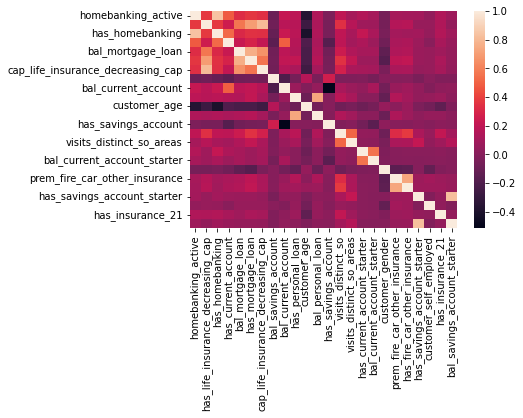

In [64]:
corrMat = X_train_df[highest_corr].corr()
sn.heatmap(corrMat, annot=False)
plt.show()

The square in the upper left corner is highly correlated, from this set of features, we could select a smaller subset. Along the diagonal are some small squares, these features also show similar correlation patterns to the other features. From these small squares, one of the two features can be left out. The one with lower correlations to other features is kept.

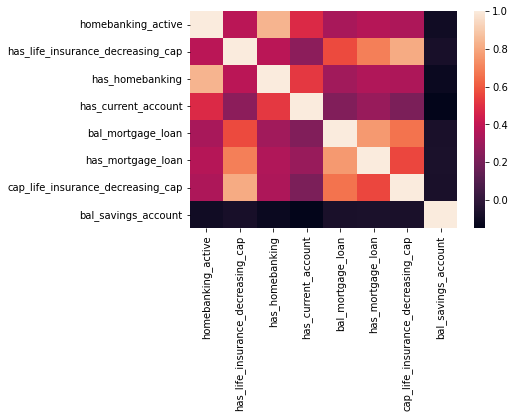

In [65]:
small_squares_drop = ['bal_current_account', 'has_personal_loan', 'visits_distinct_so', 
                      'has_current_account_starter', 'has_fire_car_other_insurance']
features_new = list(set(highest_corr) - set(small_squares_drop))  

upper_left = ['homebanking_active', 'has_life_insurance_decreasing_cap', 'has_homebanking', 
              'has_current_account', 'bal_mortgage_loan', 'has_mortgage_loan', 
              'cap_life_insurance_decreasing_cap', 'bal_savings_account']
corrMat = X_train_df[upper_left].corr()
sn.heatmap(corrMat, annot=False)
plt.show()

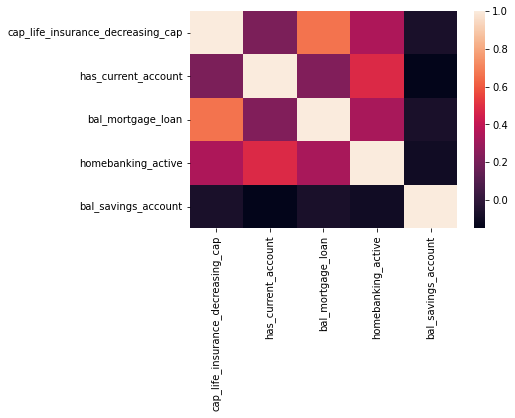

In [66]:
upper_left_drop = ['has_life_insurance_decreasing_cap', 'has_mortgage_loan', 'has_homebanking']

new_upper_left = list(set(upper_left) - set(upper_left_drop)) 
corrMat = X_train_df[new_upper_left].corr()
sn.heatmap(corrMat, annot=False)
plt.show()

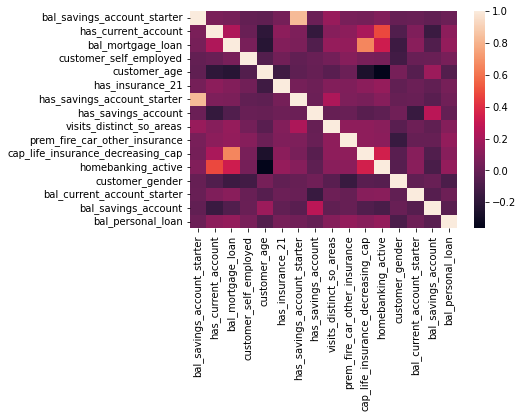

In [67]:
features_new = list(set(features_new) - set(upper_left_drop))  
corrMat = X_train_df[features_new].corr()
sn.heatmap(corrMat, annot=False)
plt.show()

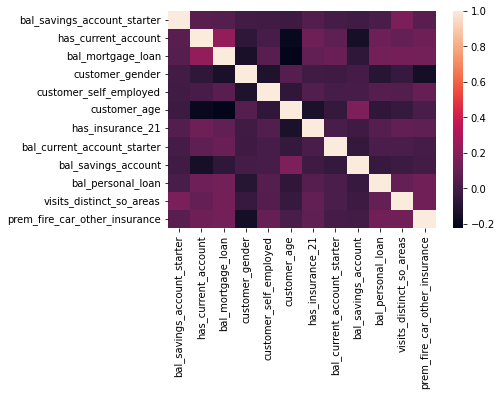

In [68]:
drop = ['homebanking_active', 'has_savings_account', 
        'cap_life_insurance_decreasing_cap', 'has_savings_account_starter']

feature_set_num = list(set(features_new) - set(drop)) 
corrMat = X_train_df[feature_set_num].corr()
sn.heatmap(corrMat, annot=False)
plt.show()

feature_set = list(feature_set_num)  + list(['customer_postal_code'])

# PCA

Convert back to a dataframe and restore the data types of the features.

In [69]:
X_train_df = to_df_restore_dtypes(X_train, train_m3, 'target')
X_train_df.drop('client_id', axis=1)

,homebanking_active,has_homebanking,has_insurance_21,has_insurance_23,has_life_insurance_fixed_cap,has_life_insurance_decreasing_cap,has_fire_car_other_insurance,has_personal_loan,has_mortgage_loan,has_current_account,...,bal_pension_saving,bal_savings_account,bal_savings_account_starter,bal_current_account_starter,visits_distinct_so,visits_distinct_so_areas,customer_gender,customer_postal_code,customer_self_employed,customer_age
0,False,False,False,False,False,False,True,False,False,True,...,0,32830,0,0,1,1,False,2050,False,71
1,False,False,True,False,False,False,False,False,False,False,...,0,6020,0,0,1,1,True,8780,False,51
2,True,True,False,False,False,True,True,False,False,False,...,0,11000,0,0,2,2,True,3580,False,42
3,False,False,False,False,False,False,True,False,False,False,...,0,10270,0,0,2,1,True,4750,True,61
4,False,False,False,False,False,False,False,False,False,True,...,0,34000,0,0,1,1,False,1190,False,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47586,True,True,False,False,False,False,True,False,False,True,...,0,11200,0,0,1,1,False,2940,False,62
47587,False,False,False,False,False,False,False,False,False,False,...,0,19880,0,0,1,1,True,2380,False,62
47588,True,True,False,False,False,False,True,False,False,True,...,0,33430,0,0,1,1,False,8400,False,81
47589,False,False,False,False,False,False,True,False,False,False,...,0,25710,0,0,1,1,True,9620,False,47


Select only the numerical features. Convert back to an array (for sklearn).

In [70]:
X_train_df = X_train_df.select_dtypes(include='number') 

print('data types:')
print(X_train_df.dtypes)

X_train_arr = X_train_df.to_numpy()

data types:
bal_insurance_21                     int64
bal_insurance_23                     int64
cap_life_insurance_fixed_cap         int64
cap_life_insurance_decreasing_cap    int64
prem_fire_car_other_insurance        int64
bal_personal_loan                    int64
bal_mortgage_loan                    int64
bal_current_account                  int64
bal_pension_saving                   int64
bal_savings_account                  int64
bal_savings_account_starter          int64
bal_current_account_starter          int64
visits_distinct_so                   int64
visits_distinct_so_areas             int64
customer_age                         int64
dtype: object


Scale the data so all feature will be considered equally important by PCA.

In [71]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_arr)

Apply PCA with the number of components such that at least 80% of variance is explained.

In [72]:
pca_80 = PCA(n_components=0.8, random_state=0)
pca_80.fit(X_scaled)

print('number of components such that at least 80% of variance is explained:', pca_80.n_components_)

number of components such that at least 80% of variance is explained: 11


Apply PCA with max number of components.

In [73]:
pca_full = PCA(random_state=0)
pca_full.fit(X_scaled)

n = 6

print('percentage of variance explained by each component:')
print(np.round(pca_full.explained_variance_ratio_,2))
print()
print('total percentage of variance explained by the first n =', n, 'components:')
print(np.round(np.sum(pca_full.explained_variance_ratio_[:n])*100), '%')

percentage of variance explained by each component:
[0.16 0.09 0.07 0.07 0.07 0.07 0.07 0.07 0.06 0.06 0.06 0.05 0.04 0.03
 0.02]

total percentage of variance explained by the first n = 6 components:
54.0 %


Project onto the first principal components.

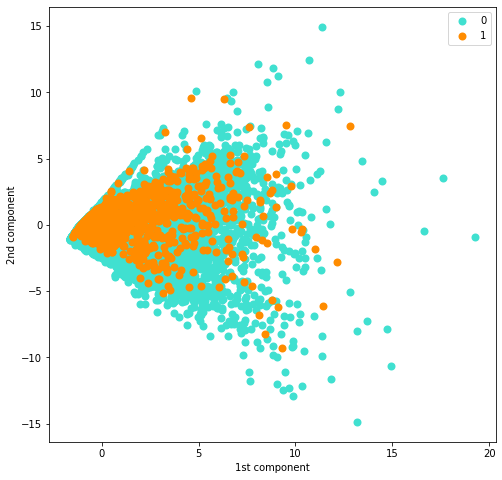

In [74]:
proj_X = pca_full.transform(X_scaled)

colors = ["turquoise", "darkorange"]

fig, ax = plt.subplots(1, 1, figsize=(8,8))
for color, i, target_name in zip(colors, [0, 1], ["0", "1"]):
    plt.scatter(
        proj_X[y_train.astype(int) == i, 0],  # 1st component 
        proj_X[y_train.astype(int) == i, 1],  # 2nd component
        #proj_X[y_train.astype(int) == i, 2],  # 3rd component
        color=color,
        lw=2,
        label=target_name,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
plt.show()

Look at how much variance in the features is explained by the components.

In [75]:
comp_features = X_train_df.columns.tolist()
components = pd.DataFrame(pca_full.components_, 
                          index = range(1, pca_full.n_components_ + 1), columns = comp_features)

print('first principal component:')
print(components.loc[1,:].sort_values(ascending=False, key=abs))

first principal component:
bal_mortgage_loan                    0.460642
cap_life_insurance_decreasing_cap    0.459301
visits_distinct_so                   0.432580
visits_distinct_so_areas             0.323305
prem_fire_car_other_insurance        0.250827
customer_age                        -0.238179
bal_current_account                  0.218044
bal_personal_loan                    0.198662
bal_insurance_21                     0.158840
bal_savings_account                 -0.138226
bal_current_account_starter          0.121397
bal_savings_account_starter          0.119815
bal_pension_saving                   0.043454
cap_life_insurance_fixed_cap         0.041731
bal_insurance_23                     0.038576
Name: 1, dtype: float64


In [76]:
D = np.diag(pca_full.explained_variance_)  # diagonal matrix of the eigenvalues (components x components)
U = pca_full.components_.transpose()  # eigenvectors (features x components)
loadings = np.dot(U, np.sqrt(D))  # loadings of the features on the components (features x components)
loadings = pd.DataFrame(loadings, index = comp_features, columns = range(1, pca_full.n_components_ + 1))

# the sum of squared loadings gives how much variance is explained by the components over which is summed
var_by_colnames = ['var_by_comp_1','var_by_comp_1-2','var_by_comp_1-3','var_by_comp_1-4','var_by_comp_1-5',
                  'var_by_comp_1-6','var_by_comp_1-7','var_by_comp_1-8','var_by_comp_1-9','var_by_comp_1-10',
                  'var_by_comp_1-11']
for i in range(len(var_by_colnames)):
    loadings[var_by_colnames[i]] = loadings.apply(lambda row: np.sum(np.square(row.iloc[:i+1])), axis = 1)

print('loadings on first 4 components:')
print(loadings.iloc[:,:4])
print()
print(loadings[['var_by_comp_1','var_by_comp_1-2']].sort_values(by='var_by_comp_1', ascending=False))

loadings on first 4 components:
                                          1         2         3         4
bal_insurance_21                   0.246965 -0.151078 -0.092903  0.487210
bal_insurance_23                   0.059978 -0.082111  0.018882  0.603393
cap_life_insurance_fixed_cap       0.064883 -0.022608  0.042590  0.290065
cap_life_insurance_decreasing_cap  0.714124  0.360471 -0.329767 -0.064603
prem_fire_car_other_insurance      0.389988 -0.378970 -0.004615 -0.232670
bal_personal_loan                  0.308881 -0.079700 -0.022013 -0.203831
bal_mortgage_loan                  0.716210  0.348740 -0.290406 -0.108872
bal_current_account                0.339017  0.229837  0.601614 -0.140018
bal_pension_saving                 0.067562 -0.083586  0.054903  0.367903
bal_savings_account               -0.214915 -0.336566 -0.615668 -0.119762
bal_savings_account_starter        0.186289 -0.252613  0.199819  0.098009
bal_current_account_starter        0.188749  0.278362  0.278093 -0.037641
visits